
# Bayessche ANOVA – UX-Gruppen vergleichen

Autor: Luca Honegger, lh@sinnhaft.ch

Quelle: Dies ist eine Python-Portierung der UXtoolbox in R von Mohsen Rafiei, https://github.com/mohsen-rafiei/UXtoolbox


## 🧠 Was macht diese Funktion?

Die Funktion `bayesian_anova()` hilft dir dabei, **mehrere Gruppen in deiner UX-Studie zu vergleichen** – zum Beispiel, ob verschiedene Designs (A, B, C) zu unterschiedlichen UX-Scores oder Bearbeitungszeiten führen.

Im Gegensatz zur klassischen ANOVA gibt diese Funktion **keine starren Ja/Nein-Antworten**, sondern zeigt:

* Wie **wahrscheinlich** es ist, dass sich die Gruppen unterscheiden
* Wie **unsicher oder sicher** diese Unterschiede sind
* Wie hoch der **wahre Mittelwert** in jeder Gruppe **sein könnte**

Du bekommst also keine p-Werte, sondern echte Wahrscheinlichkeiten – anschaulich und nachvollziehbar.


### 🔍 Was wird berechnet?

Die Funktion schätzt:

* Den **mittleren UX-Wert je Gruppe** (Design A, B, C …)
* Die **Unsicherheit** rund um diese Mittelwerte (in Form eines Intervalls)
* Eine **grafische Darstellung**, wie stark sich die Gruppen überlappen oder unterscheiden

Das Ganze basiert auf einem **Bayesschen Statistikansatz**, der besonders gut funktioniert bei:

* Kleinen Stichproben (z. B. in UX-Tests)
* Unklaren Ergebnissen, die du **probabilistisch einschätzen** willst
* Der Notwendigkeit, nicht nur „ob“, sondern auch **wie viel** und **wie sicher** zu wissen


### 🧪 Beispiel aus der Praxis

Du hast z. B. folgende Daten aus einem UX-Test:

| UX\_Score | Design |
| --------- | ------ |
| 72        | A      |
| 76        | B      |
| 85        | C      |
| …         | …      |

Dann kannst du mit folgendem Aufruf herausfinden, welches Design im Durchschnitt besser abschneidet:

```python
trace = bayesian_anova(data, value_col="completion_time", group_col="UI_Version", n_samples=2000)
```

Zusätzlich kannst du die Ergebnisse einfach visualisieren:

```python
az.plot_forest(trace, var_names=["mu"])
az.plot_posterior(trace, var_names=["mu"])
```

Du siehst dann, wie hoch der UX-Score pro Design **wahrscheinlich** ist – und ob sich die Designs **relevant unterscheiden**.


### 🎯 Warum ist das nützlich?

Bayessche Statistik gibt dir **mehr als nur ein „Signifikant oder nicht“**. Sie sagt:

* **Wie gross ist der Unterschied?**
* **Wie sicher ist das?**
* **Wie wahrscheinlich ist z.B. Design C wirklich besser als A?**

Gerade bei kleinen UX-Samples (z. B. 5–10 pro Gruppe) oder wenn klassische Tests nicht klar entscheiden, liefert dir `bayesian_anova()` **eine fundierte Grundlage für Designentscheidungen**.


### 📝 Hinweise
* Die Funktion passt sich automatisch an den Wertebereich deiner Daten an – du musst keine Statistikparameter einstellen.
* Sie ist geeignet für 2 oder mehr Gruppen.


✅ **Was sollte in den Daten gegeben sein?**
Damit die bayesian_anova() sinnvoll funktioniert, sollten:
* Mindestens zwei Gruppen vorhanden sein (z. B. Variante A und B – oder A, B, C …)
* Jede Gruppe mindestens 2–3 Werte enthalten (sonst zu wenig Information)
* Die Zielvariable numerisch und kontinuierlich sein

**❌ Wann du `bayesian_anova()` nicht verwenden solltest**
* Die Zielvariable ist nicht kontinuierlich (z.B. Binär: 0 = Nein, 1 = Ja)
* Kategorisch (z.B. ["gut", "mittel", "schlecht"])
* Ordinal: (z.B 1 = Stimme gar nicht zu, 5 = Stimme voll zu)

👉 Warum nicht?
Bayessche ANOVA nimmt an, dass deine Zielvariable metrisch und normalverteilt innerhalb jeder Gruppe ist.

**🟢 Was stattdessen?**
* Binär: → `bayesian_logistic_regression()`
* Ordinal: → Bayessches ordinales Modell (z. B. mit OrderedLogit)
* Zählwerte (Counts): → Poisson- oder Negative-Binomial-Modell

## ⚙️ `bayesian_anova`

In [3]:
import pymc as pm
import pandas as pd
import numpy as np
import arviz as az

def bayesian_anova(data, value_col, group_col, n_samples=1000, prior_sd=10):
    """
    Führt eine Bayessche ANOVA durch zur Untersuchung von Gruppenunterschieden.

    Parameters:
        data (pd.DataFrame): DataFrame mit den Daten
        value_col (str): Spaltenname der Zielvariablen (z. B. "completion_time")
        group_col (str): Spaltenname der Gruppenvariable (z. B. "UI_version")
        n_samples (int): Anzahl Posterior-Samples
        prior_sd (float): Standardabweichung für den Prior auf mu

    Returns:
        arviz.InferenceData: Enthält Posterior, Credible Intervals etc.
    """
    # Zielvariable und Gruppencodierung vorbereiten
    y = data[value_col].values
    groups = pd.Categorical(data[group_col])
    group_idx = groups.codes
    n_groups = len(groups.categories)

    # Dynamischer Mittelwert der Daten (für den Prior)
    prior_mu = y.mean()

    with pm.Model() as model:
        mu = pm.Normal('mu', mu=prior_mu, sigma=prior_sd, shape=n_groups)
        sigma = pm.HalfNormal('sigma', sigma=prior_sd)
        y_obs = pm.Normal('y_obs', mu=mu[group_idx], sigma=sigma, observed=y)

        trace = pm.sample(n_samples, return_inferencedata=True, progressbar=True)

    return trace

## 🚀 Anwendungsbeispiel

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.


array([<Axes: title={'center': 'mu\n0'}>,
       <Axes: title={'center': 'mu\n1'}>,
       <Axes: title={'center': 'mu\n2'}>], dtype=object)

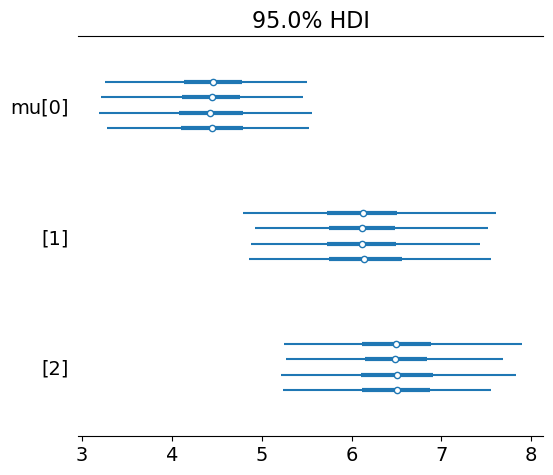

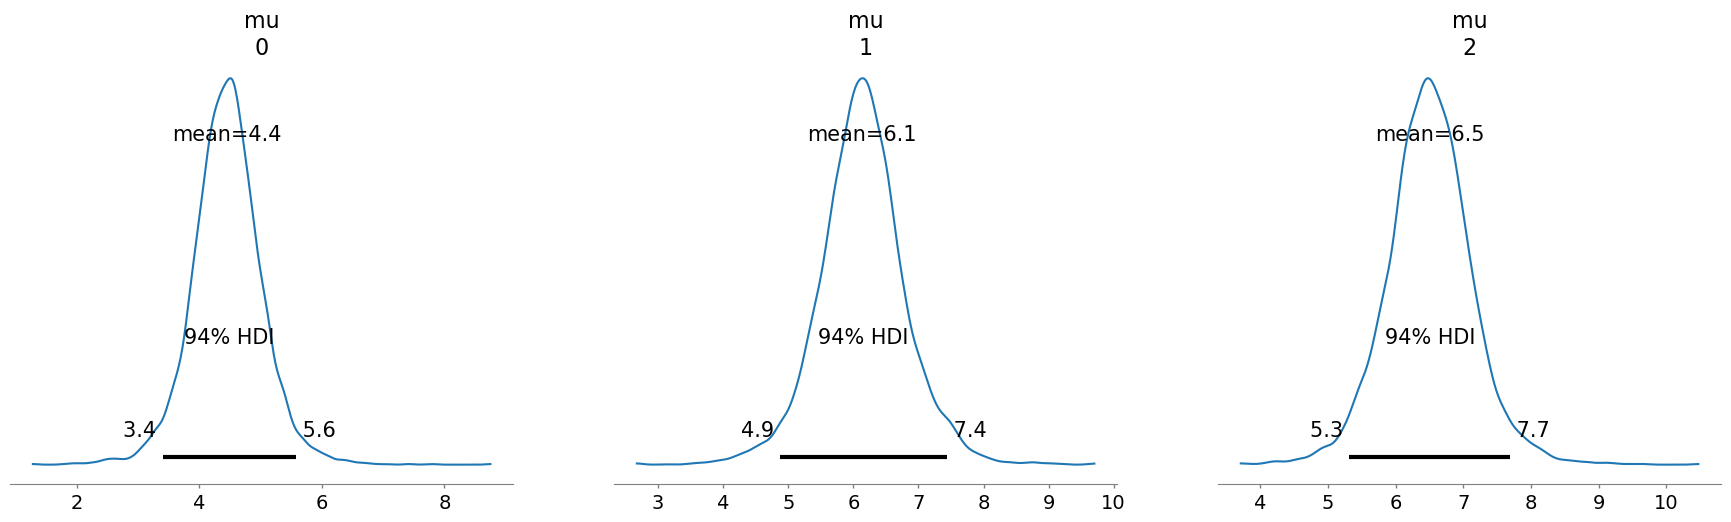

In [7]:
# Beispiel-Datensatz
# Completion Time (wie lange hat es gedauert, bis ein Task abgeschlossen wurden)
# drei verschiedene Varianten A, B und C
df = pd.DataFrame({
    "completion_time": [4.1, 6.3, 6.5, 4.8, 7.2, 6.0, 5.4, 4.9, 7.0, 3.5],
    "UI_version": ["A", "B", "C", "A", "B", "C", "A", "B", "C", "A"]
})

trace = bayesian_anova(df, "completion_time", "UI_version", n_samples=2000)

# Zusammenfassung
az.summary(trace, hdi_prob=0.95)

# Plot Credible Intervals
az.plot_forest(trace, var_names=["mu"], hdi_prob=0.95)

# Posteriorverteilungen
az.plot_posterior(trace, var_names=["mu"])

### 📖 Erklärung und Interpretation

#### Was wurde berechnet?

Es wurde eine **Bayessche ANOVA** durchgeführt, um zu prüfen, ob sich die **UX-Scores** (z. B. Zufriedenheit oder Bewertung auf einer Skala) **zwischen den drei Design-Gruppen A, B und C unterscheiden**.

Die Methode zeigt Wahrscheinlichkeitsverteilungen (Posterior) für den mittleren UX-Wert pro Gruppe, inkl. Unsicherheitsbereich (**94 %-Credible Interval**, kurz HDI).

---

#### Ergebnisse im Überblick

| Gruppe     | Geschätzter Mittelwert (mean) | 94 %-Credible Interval (HDI) |
| ---------- | ----------------------------- | ---------------------------- |
| A (mu\[0]) | 4.4                           | \[3.4, 5.5]                  |
| B (mu\[1]) | 6.1                           | \[4.9, 7.3]                  |
| C (mu\[2]) | 6.5                           | \[5.3, 7.7]                  |

---

#### Interpretation

* ✅ **Design C hat den höchsten geschätzten UX-Wert** (mean = 6.5), gefolgt von B (6.1) und A (4.4).
* ✅ Die **Credible Intervals von A vs. B und A vs. C überlappen nicht** → diese Unterschiede sind sehr wahrscheinlich echt.
* ⚠️ Die **Intervalle von B und C überlappen leicht**, daher ist **nicht mit Sicherheit** zu sagen, dass C besser ist als B – aber es ist **wahrscheinlich**.
* ❌ Für Gruppe A ergibt sich ein deutlich **niedrigerer UX-Wert** als bei den anderen Designs.

➡️ Um den Unterschied noch genauer zu bewerten, schauen wir uns die Posterior-Differenzen an:

In [23]:
# Posterior-Samples extrahieren
mu_a = trace.posterior["mu"].sel(mu_dim_0=0).values.flatten()  # Design A
mu_b = trace.posterior["mu"].sel(mu_dim_0=1).values.flatten()  # Design B
mu_c = trace.posterior["mu"].sel(mu_dim_0=2).values.flatten()  # Design C

# Alle paarweisen Differenzen
diffs = {
    "C − A": mu_c - mu_a,
    "B − A": mu_b - mu_a,
    "C − B": mu_c - mu_b
}

# Ergebnisse berechnen und ausgeben (ohne Visualisierung)
for name, diff in diffs.items():
    mean_diff = diff.mean()
    hdi = az.hdi(diff, hdi_prob=0.94)
    p_greater = (diff > 0).mean()

    print(f"📊 Vergleich: {name}")
    print(f"  • Mittlere Differenz: {mean_diff:.2f}")
    print(f"  • 94 %-Credible Interval (HDI): [{hdi[0]:.2f}, {hdi[1]:.2f}]")
    print(f"  • Wahrscheinlichkeit, dass {name} > 0: {p_greater:.3f}")
    print("")

📊 Vergleich: C − A
  • Mittlere Differenz: 2.06
  • 94 %-Credible Interval (HDI): [0.51, 3.71]
  • Wahrscheinlichkeit, dass C − A > 0: 0.988

📊 Vergleich: B − A
  • Mittlere Differenz: 1.69
  • 94 %-Credible Interval (HDI): [0.05, 3.31]
  • Wahrscheinlichkeit, dass B − A > 0: 0.973

📊 Vergleich: C − B
  • Mittlere Differenz: 0.37
  • 94 %-Credible Interval (HDI): [-1.39, 2.05]
  • Wahrscheinlichkeit, dass C − B > 0: 0.678



#### 📌 Fazit

| Erkenntnis                                                                                                         | Bedeutung                                                                     |
| ------------------------------------------------------------------------------------------------------------------ | ----------------------------------------------------------------------------- |
| ✅ **Design C zeigt den höchsten UX-Wert**                                                                          | Sehr hohe Wahrscheinlichkeit, dass C besser ist als A (98.8 %)                |
| ✅ **Design A ist klar unterlegen**                                                                                 | A liegt signifikant unter B und C – sollte überarbeitet oder verworfen werden |
| ✅ **Design B ist besser als A**                                                                                    | Hohe Wahrscheinlichkeit (97.3 %) für einen echten Unterschied                 |
| ⚠️ **Unklar, ob C besser ist als B**                                                                               | Unterschied ist klein (0.37) und unsicher (nur 67.8 %-Wahrscheinlichkeit)     |
| 📊 **Die Unterschiede sind nicht nur sichtbar, sondern auch statistisch plausibel** – dank Bayesscher Modellierung | Ergebnisse sind probabilistisch und aussagekräftig interpretiert              |
